# Comparaison de la sélection de variables avec STABL (Random Forest, XGBoost, Lasso, ElasticNet)

Ce notebook compare la sélection de variables et les performances de classification/régression entre STABL utilisant des modèles d’arbres (Random Forest, XGBoost) avec grid search, et STABL utilisant des modèles linéaires (Lasso, ElasticNet). Les résultats sont évalués par validation croisée, en termes de performances et de nombre de variables sélectionnées.

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from stabl.stabl import Stabl
from stabl.adaptive import ALasso, ALogitLasso
from stabl.preprocessing import LowInfoFilter
# from stabl.visualization import plot_fdr_graph
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



/Users/noeamar/Documents/Stanford/venv/lib/python3.11/site-packages/stabl/stabl.py:19: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Charger et explorer les données

Nous allons charger un jeu de données tabulaire (exemple : CyTOF.csv et outcome.csv), afficher ses dimensions, types de variables, et quelques statistiques descriptives.

Features shape: (177, 1216)
Outcome shape: (177, 1)
Features columns: ['cMCs_HLADR_GMCSF', 'MDSCs_IkB_GMCSF', 'intMCs_pCREB_GMCSF', 'Granulocytes_pERK_GMCSF', 'MDSCs_pERK_GMCSF', 'cMCs_pERK_GMCSF', 'intMCs_pERK_GMCSF', 'ncMCs_pERK_GMCSF', 'pDCs_pERK_GMCSF', 'Granulocytes_pNFkB_GMCSF'] …
Outcome columns: ['DOS']

=== Statistiques descriptives des features ===
                         count      mean       std       min       25%  \
cMCs_HLADR_GMCSF         177.0  4.668894  0.635174  2.819139  4.419004   
MDSCs_IkB_GMCSF          177.0 -0.192023  0.070885 -0.359435 -0.243705   
intMCs_pCREB_GMCSF       177.0  0.371124  0.192806 -0.228241  0.301780   
Granulocytes_pERK_GMCSF  177.0  0.051222  0.029717 -0.002079  0.031515   
MDSCs_pERK_GMCSF         177.0 -0.222357  0.104227 -0.533919 -0.271677   
...                        ...       ...       ...       ...       ...   
pDCs_pS6_Unstim          151.0  0.372886  0.199852  0.000000  0.278250   
pDCs_pSTAT1_Unstim       151.0  0.011949  0.082

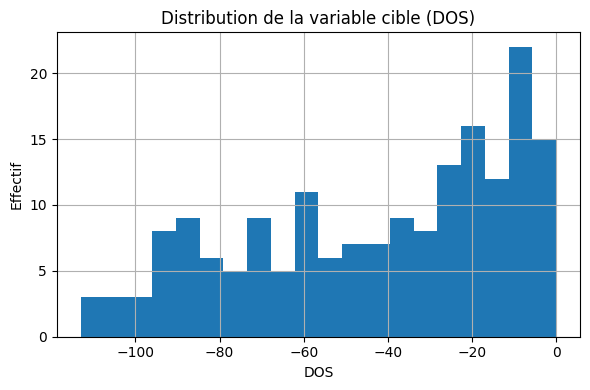

In [2]:
# 1. Charger les données

features_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/ina_13OG_df_168_filtered_allstim_new.csv"
outcome_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/outcome_table_all_pre.csv"

features = pd.read_csv(features_path, index_col=0)
outcome = pd.read_csv(outcome_path, index_col=0, dtype={"DOS": int})

# 2. Garder seulement les patients présents dans les deux fichiers
common_idx = features.index.intersection(outcome.index)
features = features.loc[common_idx]
outcome  = outcome.loc[common_idx]

# 3. Extraire la série cible
y = outcome["DOS"]

# 4. Diagnostic rapide
print("Features shape:", features.shape)
print("Outcome shape:",  outcome.shape)
print("Features columns:", features.columns.tolist()[:10], "…")
print("Outcome columns:",  outcome.columns.tolist())

print("\n=== Statistiques descriptives des features ===")
print(features.describe().T)

print("\n=== Statistiques descriptives de DOS ===")
print(y.describe())

# 5. Histogramme de la variable continue DOS
plt.figure(figsize=(6,4))
y.hist(bins=20)
plt.title("Distribution de la variable cible (DOS)")
plt.xlabel("DOS")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()


## 2. Définir le préprocessing

Pipeline de préprocessing : imputation, standardisation, filtrage faible variance, filtrage low info.

## Configuration des pipelines STABL avec modèles d’arbres et linéaires

Dans cette section, nous allons configurer plusieurs pipelines de sélection de variables et de modélisation :
- **STABL + Random Forest** : sélection de variables avec STABL utilisant Random Forest comme estimateur, avec recherche de grille (grid search) pour optimiser les hyperparamètres, et validation croisée (cross-validation).
- **STABL + XGBoost** : même principe, mais avec XGBoost comme estimateur.
- **STABL + Lasso** : pipeline linéaire utilisant Lasso.
- **STABL + ElasticNet** : pipeline linéaire utilisant ElasticNet.

Pour chaque pipeline, nous appliquerons la sélection de variables, puis nous évaluerons les performances en cross-validation et le nombre de variables sélectionnées. Les résultats seront comparés à la fin du notebook.

## Cross-validation, sauvegarde des résultats et visualisation

Pour chaque modèle, nous allons :
- Effectuer une cross-validation (stratifiée) sur le dataset.
- Sauvegarder les courbes ROC et PR dans le dossier `Benchmarks results/` avec le nom du modèle et du dataset.
- Sauvegarder les importances des variables sélectionnées et leur nombre.
- Comparer les performances (AUC, accuracy, etc.) et le nombre de variables sélectionnées entre tous les modèles.

Les résultats seront visualisés sous forme de tableaux et de graphes pour faciliter la comparaison.

## Conclusion

Ce notebook permet de comparer la sélection de variables et les performances de classification entre STABL (Random Forest, XGBoost, Lasso, ElasticNet) sur le dataset CyTOF. Les courbes ROC, PR, importances des variables et tableaux de résultats sont sauvegardés dans le dossier `Benchmarks results/` avec des noms explicites pour chaque modèle et dataset. Vous pouvez adapter ce pipeline à d'autres datasets en modifiant la section de chargement des données.

In [3]:
# Pipeline de préprocessing (à utiliser dans chaque pipeline)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from stabl.preprocessing import LowInfoFilter

preprocessing = Pipeline([
    ("variance_threshold", VarianceThreshold(threshold=0)),
    ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

In [ ]:
# ===============================
# 1. Imports et configuration générale
# ===============================
import os
import shutil
import numpy as np
import pandas as pd
from stabl import data
from stabl.multi_omic_pipelines import multi_omic_stabl_cv
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from stabl.stabl import Stabl
from stabl.adaptive import ALogitLasso
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from stabl.data import load_onset_data
from pathlib import Path
from sklearn.linear_model import ElasticNet

np.random.seed(42)

# ===============================
# 2. Définition des splits de validation croisée
# ===============================
# Outer CV pour l'évaluation globale, inner CV pour la recherche d'hyperparamètres
outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# ===============================
# 3. Définition des estimateurs et grilles d'hyperparamètres
# ===============================
artificial_type = "knockoff"  # ou "random_permutation"

# Lasso
lasso = Lasso(max_iter=int(1e6), random_state=42)
lasso_cv = GridSearchCV(lasso, param_grid={"alpha": np.logspace(-2, 2, 30)}, scoring="r2", cv=inner_cv, n_jobs=-1)

#ElasticNet
en = ElasticNet(max_iter=int(1e6), random_state=42)
en_params = {"alpha": np.logspace(-2, 2, 10), "l1_ratio": [0.5, 0.7, 0.9]}
en_cv = GridSearchCV(en, param_grid=en_params, scoring="r2", cv=inner_cv, n_jobs=-1)

# RandomForest
rf = RandomForestRegressor(random_state=42, max_features=0.2)
rf_grid = {"max_depth": [3, 5, 7, 9, 11]}
rf_cv = GridSearchCV(rf, scoring='r2', param_grid=rf_grid, cv=inner_cv, n_jobs=-1)

# XGBoost
xgb = XGBRegressor(random_state=42, importance_type="gain", objective="reg:squarederror")
xgb_grid = {"max_depth": [3, 6, 9], "reg_alpha": [0, 1, 2, 5]}
xgb_cv = GridSearchCV(xgb, scoring='r2', param_grid=xgb_grid, cv=inner_cv, n_jobs=-1)

# CatBoost
cb = CatBoostRegressor(random_state=42)
cb_grid = {"depth": [3, 5, 7], "learning_rate": [0.01, 0.1, 0.2], "l2_leaf_reg": [1, 3, 5]}
cb_cv = GridSearchCV(cb, scoring='r2', param_grid=cb_grid, cv=inner_cv, n_jobs=-1, verbose=0)

# LightGBM
lgb = LGBMRegressor(random_state=42)
lgb_grid = {"max_depth": [4, 6, 8], "learning_rate": [0.01, 0.1], "num_leaves": [31, 63, 127], "reg_alpha": [0, 1], "reg_lambda": [0, 1]}
lgb_cv = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring="r2", cv=inner_cv, n_jobs=-1)

# ===============================
# 4. Définition des estimateurs STABL
# ===============================
stabl_lasso = Stabl(
    base_estimator=lasso,
    n_bootstraps=100,
    artificial_type=artificial_type,
    artificial_proportion=1.,
    replace=False,
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    sample_fraction=0.5,
    random_state=42,
    lambda_grid={"alpha": np.logspace(-2, 2, 10)},
    verbose=1
)

stabl_en = clone(stabl_lasso).set_params(
    base_estimator=en,
    n_bootstraps=100,
    lambda_grid=[{"C": np.logspace(-2, 1, 5), "l1_ratio": [0.5, 0.9]}],
    verbose=1
)

stabl_rf = clone(stabl_lasso).set_params(
    base_estimator=rf,
    n_bootstraps=100,
    lambda_grid=rf_grid,
    verbose=1
)

stabl_xgb = clone(stabl_lasso).set_params(
    base_estimator=xgb,
    n_bootstraps=100,
    lambda_grid=[xgb_grid],
    verbose=1
)

stabl_cb = clone(stabl_lasso).set_params(
    base_estimator=cb,
    n_bootstraps=100,
    lambda_grid=[cb_grid],
    verbose=1
)

stabl_lgb = clone(stabl_lasso).set_params(
    base_estimator=lgb,
    n_bootstraps=100,
    lambda_grid=[lgb_grid],
    verbose=1
)

# ===============================
# 5. Dictionnaire des estimateurs pour le benchmark
# ===============================
estimators = {
    "lasso": lasso_cv,
    "rf": rf_cv,
    "xgb": xgb_cv,
#   "cb": cb_cv,
#   "lgb": lgb_cv,
    "stabl_lasso": stabl_lasso,
    "stabl_rf": stabl_rf,
    "stabl_xgb": stabl_xgb,
#   "stabl_cb" : stabl_cb,
#   "stabl_lgb": stabl_lgb,
    }

models = [
    "Lasso",
    "RandomForest",
    "XGBoost",
#    "CatBoost",
#    "LightGBM",
    "STABL Lasso",
    "STABL RandomForest",
    "STABL XGBoost",
#    "STABL CatBoost"
#    "STABL LightGBM"
]


# juste après avoir construit ton dict estimators, ajoute :
estimators["en"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_en"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["cb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_cb"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["lgb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_lgb"]  = estimators["stabl_lasso"]  # placeholder vide


# final_classifiers = {"Logit": LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", max_iter=int(1e6), random_state=42),
#                      "RandomForest": RandomForestClassifier(n_estimators=500, random_state=42),
#                      "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=200,random_state=42),
#                     }


# ===============================
# 6. Chargement des données (exemple COVID-19)
# ===============================
# X_train, X_valid, y_train, y_valid, ids, task_type = data.load_covid_19("data/COVID-19")
X_train, X_val, y_train, y_val, groups, task_type = load_onset_data(features_path, outcome_path)

# ===============================
# 7. Lancement du benchmark multi-omic STABL
# ===============================
save_path = "./Benchmarks results/Regresssion data Olivier + XGB/KO"

# Nettoyage du dossier de sauvegarde si besoin
if os.path.exists(save_path):
    shutil.rmtree(save_path)

print("Run CV on Olivier dataset")
# print(groups.value_counts())

multi_omic_stabl_cv(
    data_dict=X_train,
    y=y_train,
    outer_splitter=outer_cv,
    estimators=estimators,
    task_type=task_type,
    save_path=save_path,
    outer_groups=groups,
    early_fusion=False,
    late_fusion=True,
    n_iter_lf=1000,
    models=models
)

Run CV on Olivier dataset
Stabl progress: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
STABL Lasso finished on Unstim (141 samples); 0 features selected
Fitting of STABL RandomForest
Stabl progress: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
STABL RandomForest finished on Unstim (141 samples); 8 features selected
Fitting of STABL XGBoost
Stabl progress: 100%|██████████| 12/12 [00:25<00:00,  2.10s/it]
STABL XGBoost finished on Unstim (141 samples); 7 features selected
Fitting of Lasso
Lasso finished on Unstim (141 samples); 0 features selected
Fitting of RandomForest
RandomForest finished on Unstim (141 samples); 152 features selected
Fitting of XGBoost
XGBoost finished on Unstim (141 samples); 124 features selected
Fitting of STABL Lasso
Stabl progress: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]
STABL Lasso finished on TNFa (133 samples); 0 features selected
Fitting of STABL RandomForest
Stabl progress: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
STABL RandomForest finishe

Late Fusion XGBoost: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This fold: 37 features selected for Lasso
This fold: 854 features selected for RandomForest
This fold: 784 features selected for XGBoost
This fold: 10 features selected for STABL Lasso
This fold: 57 features selected for STABL RandomForest
This fold: 39 features selected for STABL XGBoost
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

141 train samples, 36 test samples:   7%|▋         | 1/15 [08:34<1:59:59, 514.24s/it]

Fitting of STABL Lasso
Stabl progress: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
STABL Lasso finished on Unstim (141 samples); 1 features selected
Fitting of STABL RandomForest
Stabl progress: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]
STABL RandomForest finished on Unstim (141 samples); 5 features selected
Fitting of STABL XGBoost
Stabl progress: 100%|██████████| 12/12 [00:36<00:00,  3.06s/it]
STABL XGBoost finished on Unstim (141 samples); 6 features selected
Fitting of Lasso
141 train samples, 36 test samples:   7%|▋         | 1/15 [09:23<2:11:31, 563.66s/it]


ValueError: n_splits=5 cannot be greater than the number of members in each class.

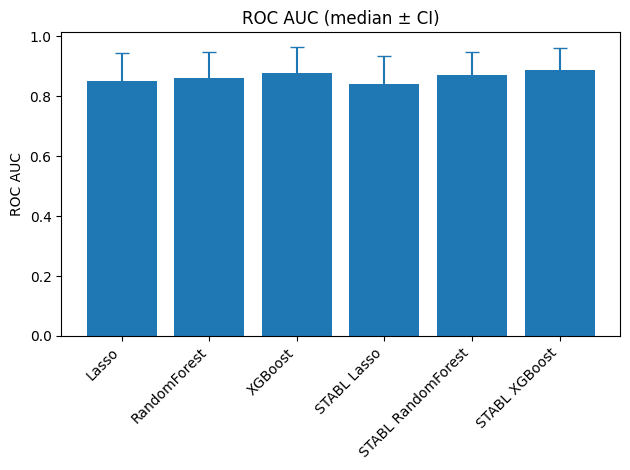

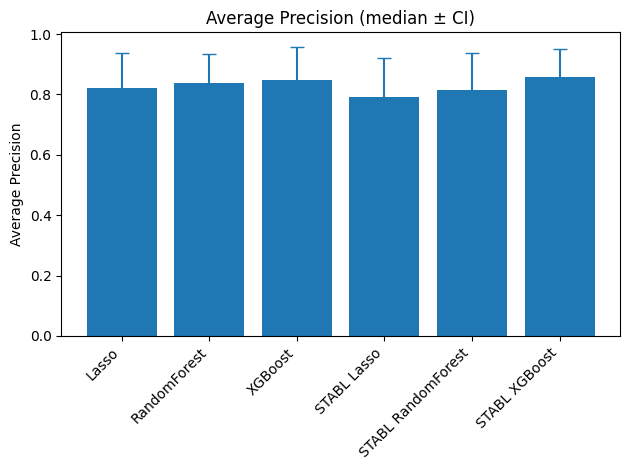

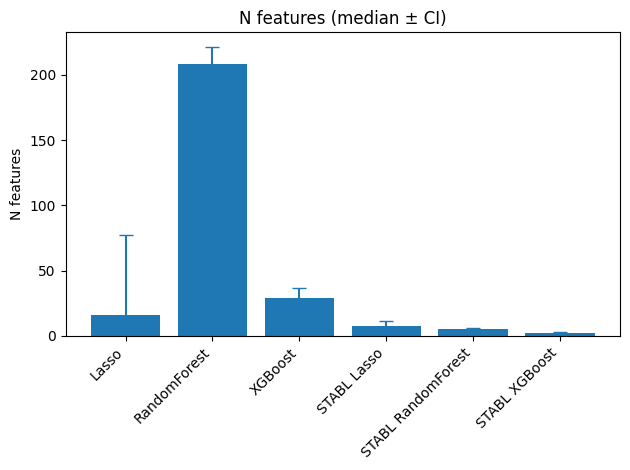

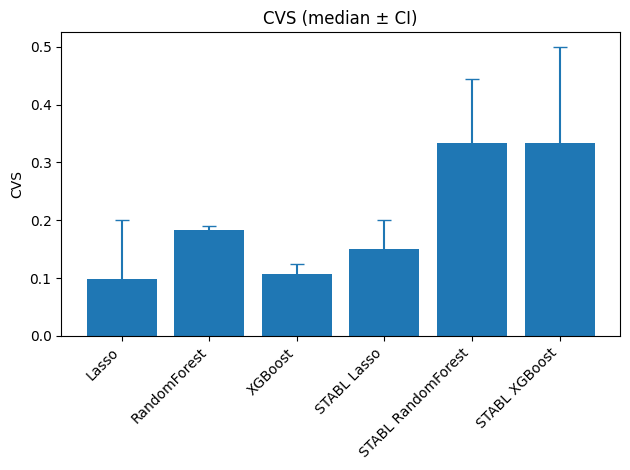

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# ------------------------------------------------------------------
# 1) Charger le fichier CSV
#    ➜ remplace "results_metrics.csv" par le chemin réel de ton CSV
# ------------------------------------------------------------------
csv_path = "/Users/noeamar/Documents/Stanford/Benchmarks results/Binary COVID-19 + Logit/Summary/Scores training CV.csv"
df = pd.read_csv(csv_path, index_col=0)

# ------------------------------------------------------------------
# 2) Extraire médiane, borne basse et borne haute
#    Exemple "0.852 [0.735, 0.943]"  →  median=0.852, low=0.735, high=0.943
# ------------------------------------------------------------------
pattern = re.compile(r"([0-9.]+)\s*\[\s*([0-9.]+)\s*,\s*([0-9.]+)\s*\]")

median_df, low_df, high_df = pd.DataFrame(index=df.index), pd.DataFrame(index=df.index), pd.DataFrame(index=df.index)

for col in df.columns:
    med, low, high = [], [], []
    for val in df[col]:
        m = pattern.match(str(val))
        if m:
            med_val, low_val, high_val = map(float, m.groups())
        else:                 # si la cellule ne suit pas le pattern
            med_val = low_val = high_val = float(val)
        med.append(med_val); low.append(low_val); high.append(high_val)
    median_df[col] = med
    low_df[col]    = low
    high_df[col]   = high

# ------------------------------------------------------------------
# 3) Un bar-plot par métrique avec barres d’erreur (CI)
#    (un graphique indépendant par métrique, sans sous-plots)
# ------------------------------------------------------------------
for metric in median_df.columns:
    med  = median_df[metric]
    lower_err = med - low_df[metric]
    upper_err = high_df[metric] - med
    yerr = [lower_err, upper_err]

    plt.figure()
    plt.bar(med.index, med.values)
    plt.errorbar(x=range(len(med)), y=med.values, yerr=yerr, fmt='none', capsize=5)
    plt.title(f"{metric} (median ± CI)")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
